In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from unet import UNetModel
from diffusion import GaussianDiffusionSchedule

from dataset import FewShotDataset, mask_cmap_colors, mask_cmap

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import gc

device = torch.device('cuda:0')

## Load diffusion model

In [3]:
diff_net = UNetModel(image_size=256, in_channels=3, out_channels=6, 
                     model_channels=256, num_res_blocks=2, channel_mult=(1, 1, 2, 2, 4, 4),
                     attention_resolutions=[32,16,8], num_head_channels=64, dropout=0.1, resblock_updown=True, use_scale_shift_norm=True).to(device)
diff_net.load_state_dict(torch.load('../../ffhq_seg/models/ffhq.pt', map_location=device))

print('Loaded Diffusion Model')
print(f'# parameters: {sum([p.numel() for p in diff_net.parameters()]):,}')

Loaded Diffusion Model
# parameters: 552,814,086


## Select features to use

In [4]:
# Add hooks
def get_features(name):
    def hook(model, input, output):
        features[name] = output
    return hook

# Concatenate feature maps into a single input tensor
def get_input(features):
    input_features = torch.cat((features['1'],
                                F.interpolate(features['2'], scale_factor=2),
                                F.interpolate(features['3'], scale_factor=4),
                                ), dim=1)
    return input_features

# Intermediate layers to use
hook1 = diff_net.output_blocks[14].register_forward_hook(get_features('1'))
hook2 = diff_net.output_blocks[12].register_forward_hook(get_features('2'))
hook3 = diff_net.output_blocks[10].register_forward_hook(get_features('3'))

# Extract intermediate features
features = {}
x = diff_net(torch.randn((1,3,256,256)).float().to(device), torch.tensor([np.random.randint(0, 1000)]).float().to(device))
y = get_input(features)
print('Using features of shape:', y.shape)

Using features of shape: torch.Size([1, 1024, 256, 256])


## Train segmentation network using denoiser features

In [6]:
# Dataset can be found at https://github.com/yandex-research/ddpm-segmentation
n_classes = 19
train_data = FewShotDataset('../../ffhq_seg/data/celeba_19/real/train/')
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)
        
test_data = FewShotDataset('../../ffhq_seg/data/celeba_19/real/test/', augment=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

Loaded 20 images from '../../ffhq_seg/data/celeba_19/real/train/'
Loaded 500 images from '../../ffhq_seg/data/celeba_19/real/test/'


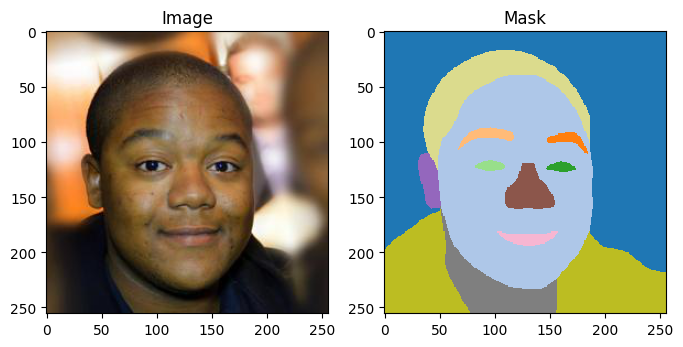

In [7]:
for batch in train_dataloader:
    img, mask = batch
    img = 2*img - 1
    break

fig, ax = plt.subplots(1, 2, figsize=(8,5))
ax[0].imshow((0.5*(img+1))[0].numpy().transpose([1,2,0]))
ax[0].set_title('Image')
ax[1].imshow(mask[0].numpy(), cmap=mask_cmap, vmin=0, vmax=mask_cmap_colors.shape[0], interpolation='none')
ax[1].set_title('Mask')
plt.show()

In [8]:
class SegNet(nn.Module):
    def __init__(self, in_ch=256, hidden=64, num_classes=19):
        super(SegNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_ch, hidden, 1)
        self.conv2 = nn.Conv2d(hidden, hidden, 1)
        self.conv3 = nn.Conv2d(hidden, hidden, 1)
        self.conv4 = nn.Conv2d(hidden, num_classes, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        
        return x

# of parameters 75,155


  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


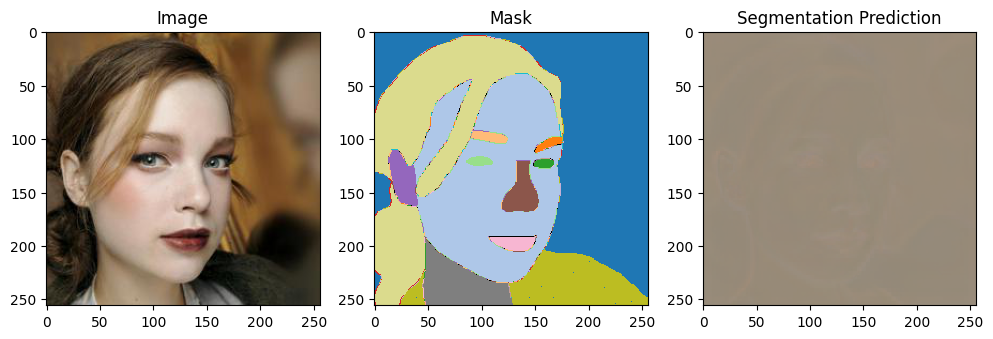

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


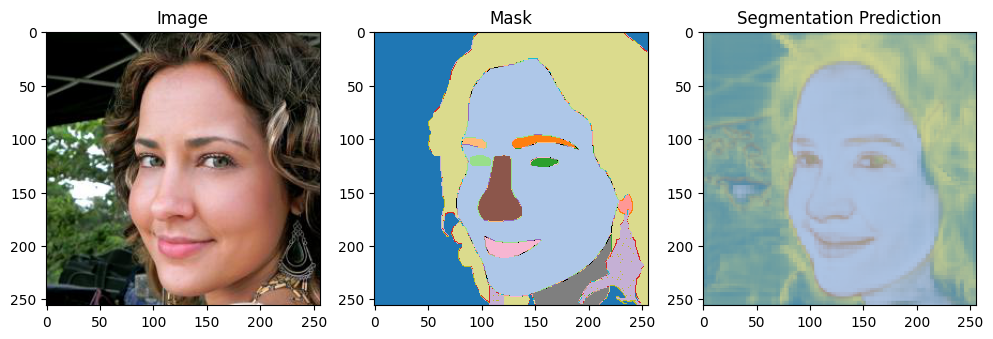

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


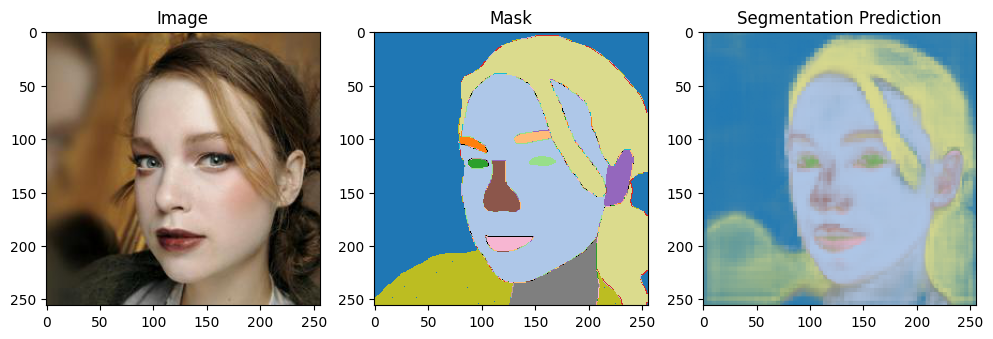

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


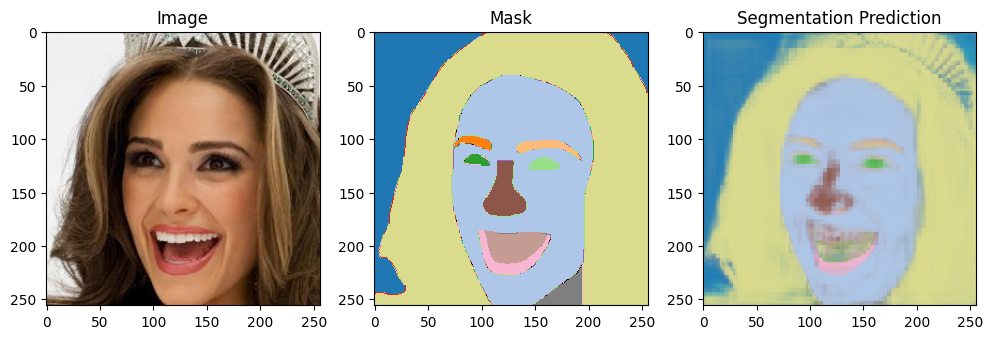

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


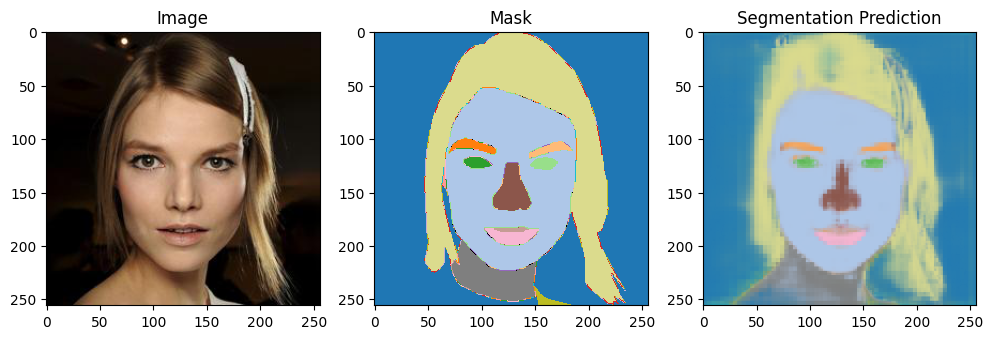

In [9]:
seg_model = SegNet(in_ch=1024).to(device)
seg_model.train()
print(f'# of parameters {sum([p.numel() for p in seg_model.parameters()]):,}')
opt = torch.optim.Adam(seg_model.parameters(), lr=5e-4)

diff_net.eval()

t_features = 500 # Timestep to extract features at
epochs = 50 # Total epochs to train for
update_every = 20
vis_every = 50
i = 0
losses = []

progress_bar = tqdm(range(epochs))
for e in progress_bar:
    for batch in train_dataloader:
        img, mask = batch
        img = 2*img - 1
        
        # Get features from U-Net
        with torch.no_grad():            
            x = diff_net(img.float().to(device), torch.tensor([t_features]).float().to(device))
            input_features = get_input(features)
            
        # Predict logits
        logits = seg_model(input_features)
        # Compute loss   
        loss = F.cross_entropy(logits, mask.long().to(device))
        # Update parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if i % update_every == 0:
            progress_bar.set_postfix({'Loss': np.mean(losses)})
            losses = []
            
        if i % vis_every == 0:
            img_vis = logits[0].softmax(0).detach().cpu().numpy()
            img_vis = np.einsum('lhw,ld->hwd', img_vis, mask_cmap_colors[:n_classes,:])

            fig, ax = plt.subplots(1, 3, figsize=(12,5))
            ax[0].imshow((0.5*(img+1))[0].numpy().transpose([1,2,0]))
            ax[0].set_title('Image')
            ax[1].imshow(mask[0].numpy(), cmap=mask_cmap, vmin=0, vmax=mask_cmap_colors.shape[0])
            ax[1].set_title('Mask')
            ax[2].imshow(img_vis)
            ax[2].set_title('Segmentation Prediction')
            plt.show()
        
        i += 1

In [10]:
# Clean-up
opt.zero_grad()
del opt
del loss
del logits
del input_features
del x

gc.collect()
torch.cuda.empty_cache()

## Guided inference

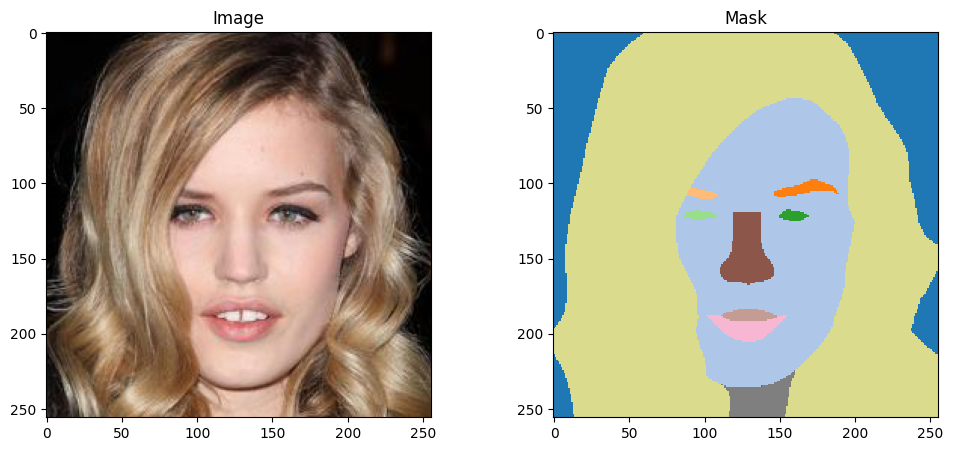

In [11]:
# Grab a random sample from the test set
for batch in test_dataloader:
    img, mask = batch
    img = 2*img - 1

    img = img[[0],...]
    mask = mask[[0],...]
    break

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].imshow((0.5*(img+1))[0].numpy().transpose([1,2,0]))
ax[0].set_title('Image')
ax[1].imshow(mask[0].numpy(), cmap=mask_cmap, vmin=0, vmax=mask_cmap_colors.shape[0], interpolation='none')
ax[1].set_title('Mask')
plt.show()

Running diffusion with 50 steps


0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


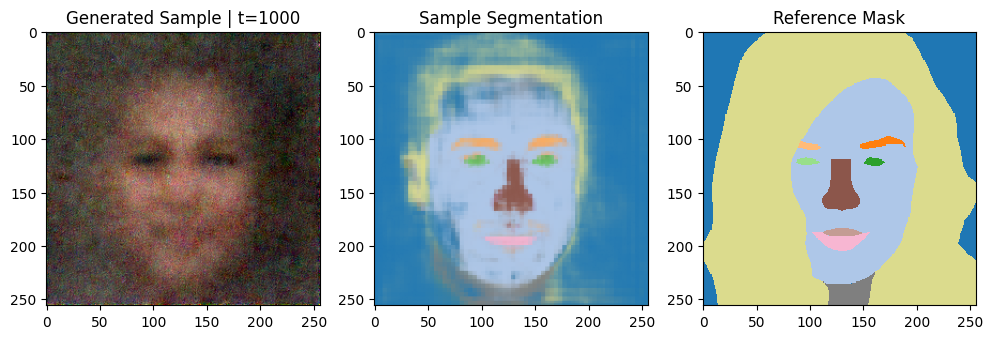

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


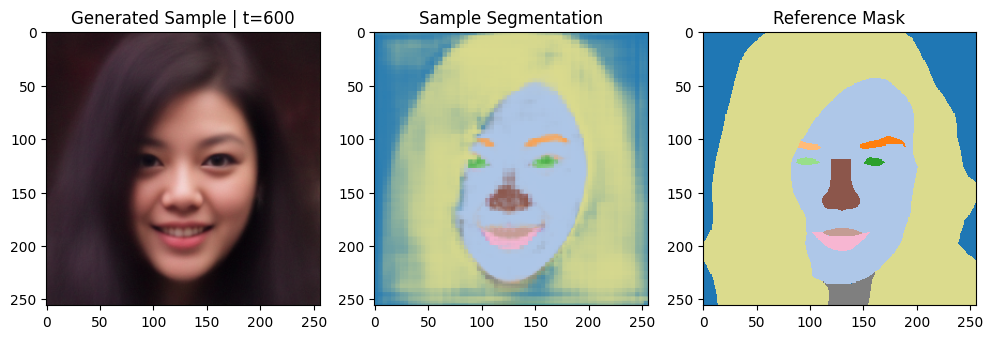

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


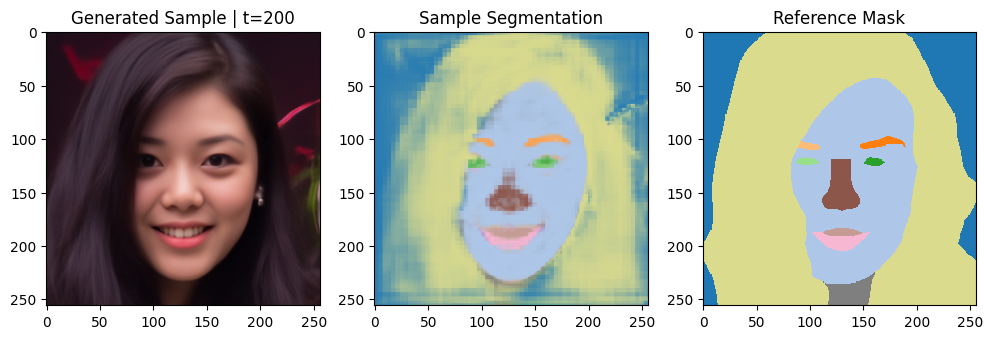

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


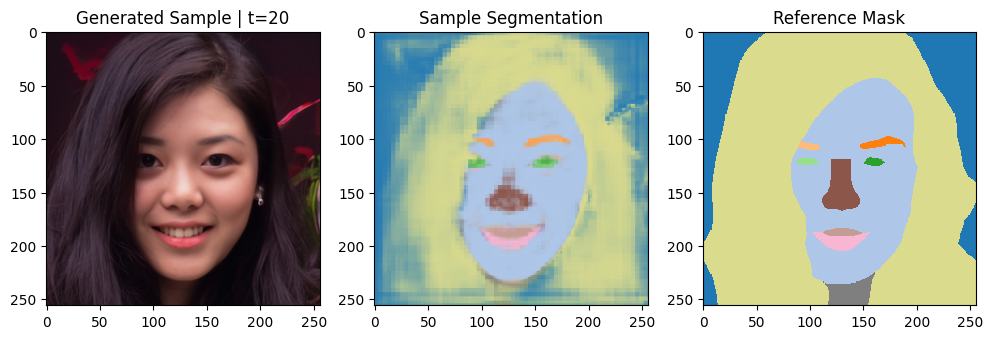

In [13]:
seg_model.eval()

# Initialize xT
t0 = 1000
x = torch.randn((1,3,256,256)).float().to(device)
x.requires_grad = True

# Reference
target = mask[0].tile(1,1,1).long().to(device)

# Mask guidance
guidance_weight = 25

# Diffusion process parameters
stride = 20
start_t = t0
steps = t0
t_range = list(range(start_t, start_t-steps, -stride))
print(f"Running diffusion with {len(t_range)} steps")

ddim = 1
diffusion = GaussianDiffusionSchedule(T=1000, schedule='linear')

vis_every = 20

# Run inference
for j, t in tqdm(enumerate(t_range)):
    if j != len(t_range) - 1:
        stride = t - t_range[j+1]
    else:
        stride = t
    
    at = diffusion.alpha[t-1]
    atbar = diffusion.alphabar[t-1]

    # Diffusion score
    t_cond = torch.tensor([t]).view(1)
    epsilon = diff_net(x, t_cond.float().to(device))[:,:3,:,:]
    # x0 estimation
    x0_pred = (x.float() / np.sqrt(atbar)) - (epsilon * np.sqrt((1-atbar)/atbar))

    # Learned guidance
    x_diff = diff_net(x0_pred.float().to(device), torch.tensor([t_features]).float().to(device))
    input_features = get_input(features)
    seg = seg_model(input_features)
    seg_loss = -guidance_weight*F.cross_entropy(seg, target)
    guidance_loss = seg_loss
    # Comptue guidance score and update epsilon
    x.grad = None
    grad = torch.autograd.grad(guidance_loss, x, grad_outputs=torch.ones_like(guidance_loss))[0]    
    epsilon = epsilon - np.sqrt(1-atbar)*grad

    # Perform denoising step
    if t > stride:
        z = torch.randn_like(x)
        atbar_prev = diffusion.alphabar[t-1-stride]
        beta_tilde = diffusion.beta[t-1] * (1 - atbar_prev) / (1 - atbar) 
    else:
        z = torch.zeros_like(x)
        atbar_prev = 1
        beta_tilde = 0

    with torch.no_grad():
        beta_tilde = beta_tilde * ddim
        x = np.sqrt(atbar_prev) * (x - np.sqrt(1-atbar)*epsilon) / np.sqrt(atbar) + np.sqrt(1-atbar_prev-beta_tilde)*epsilon + np.sqrt(beta_tilde) * z
    x.requires_grad = True

    if (j % vis_every == 0) or (j == len(t_range)-1):
        img_vis = seg[0].softmax(0).detach().cpu().numpy()
        img_vis = np.einsum('lhw,ld->hwd', img_vis, mask_cmap_colors[:n_classes,:])

        fig, ax = plt.subplots(1, 3, figsize=(12,5))
        ax[0].imshow((0.5*(x0_pred+1))[0].detach().cpu().numpy().transpose([1,2,0]))
        ax[0].set_title(f'Generated Sample | t={t}')
        ax[1].imshow(img_vis)
        ax[1].set_title('Sample Segmentation')
        ax[2].imshow(target[0].cpu().numpy(), cmap=mask_cmap, vmin=0, vmax=mask_cmap_colors.shape[0], interpolation='none')
        ax[2].set_title('Reference Mask')
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


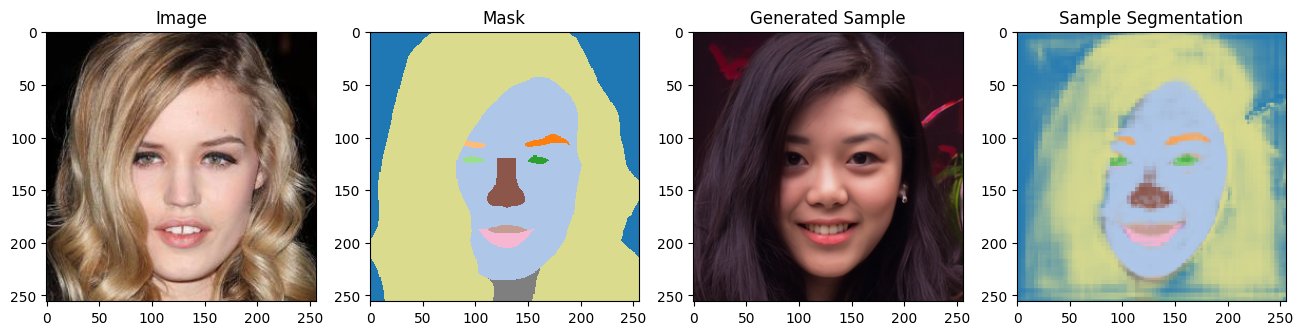

In [14]:
img_vis = seg[0].softmax(0).detach().cpu().numpy()
img_vis = np.einsum('lhw,ld->hwd', img_vis, mask_cmap_colors[:n_classes,:])

fig, ax = plt.subplots(1, 4, figsize=(16,5))
ax[0].imshow((0.5*(img+1))[0].numpy().transpose([1,2,0]))
ax[0].set_title('Image')
ax[1].imshow(mask[0].numpy(), cmap=mask_cmap, vmin=0, vmax=mask_cmap_colors.shape[0], interpolation='none')
ax[1].set_title('Mask')
ax[2].imshow((0.5*(x+1))[0].detach().cpu().numpy().transpose([1,2,0]))
ax[2].set_title('Generated Sample')
ax[3].imshow(img_vis)
ax[3].set_title('Sample Segmentation')
plt.show()